# Task 4: Autoencoder
Dmytro Geleshko

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn import metrics

## TF Config

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data
### Loading

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("Train X:", X_train.shape, X_train.dtype)
print("Train y:", y_train.shape, y_train.dtype)
print("Test X:", X_test.shape, X_test.dtype)
print("Test y:", y_test.shape, y_test.dtype)

Train X: (60000, 28, 28) uint8
Train y: (60000,) uint8
Test X: (10000, 28, 28) uint8
Test y: (10000,) uint8


### Preview

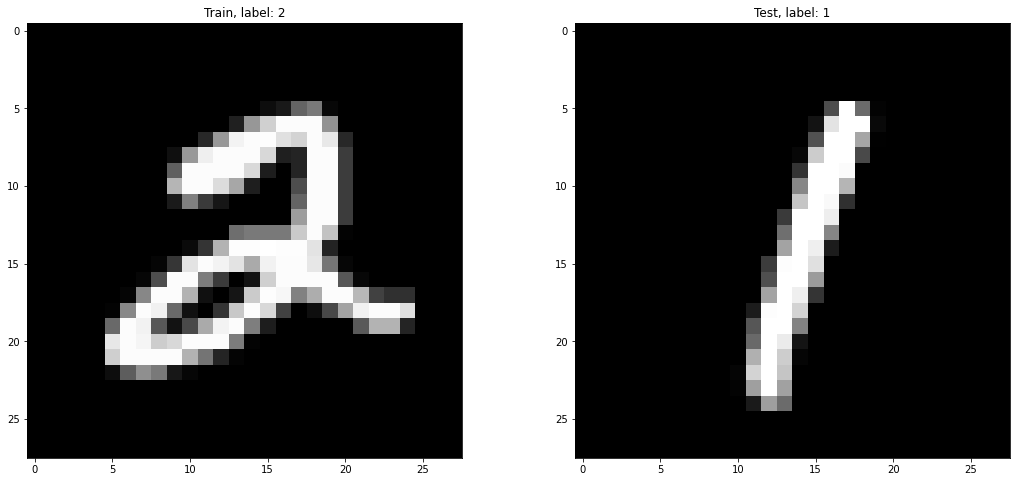

In [5]:
example = 5
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 2, 1)
plt.imshow(X_train[example], "gray")
plt.title("Train, label: " + str(y_train[example]))

plt.subplot(1, 2, 2)
plt.imshow(X_test[example], "gray")
plt.title("Test, label: " + str(y_test[example]))

plt.show()

### Reshape and Cast

In [6]:
X_train = (X_train.reshape(-1, 28 * 28) / 255).astype(np.float32)
X_test = (X_test.reshape(-1, 28 * 28) / 255).astype(np.float32)


print("Train X:", X_train.shape, X_train.dtype)
print("Test X:", X_test.shape, X_test.dtype)

Train X: (60000, 784) float32
Test X: (10000, 784) float32


### Introducing noise

In [7]:
def add_noise(data, mean, std, min_clip, max_clip):
    return np.clip(
        data + np.random.normal(mean, std, size=data.shape),
        a_min=min_clip, a_max=max_clip, dtype=np.float32)

In [8]:
X_train_noise = add_noise(X_train, mean=0, std=0.2, min_clip=0, max_clip=1)
X_test_noise = add_noise(X_test, mean=0, std=0.2, min_clip=0, max_clip=1)

### Preview

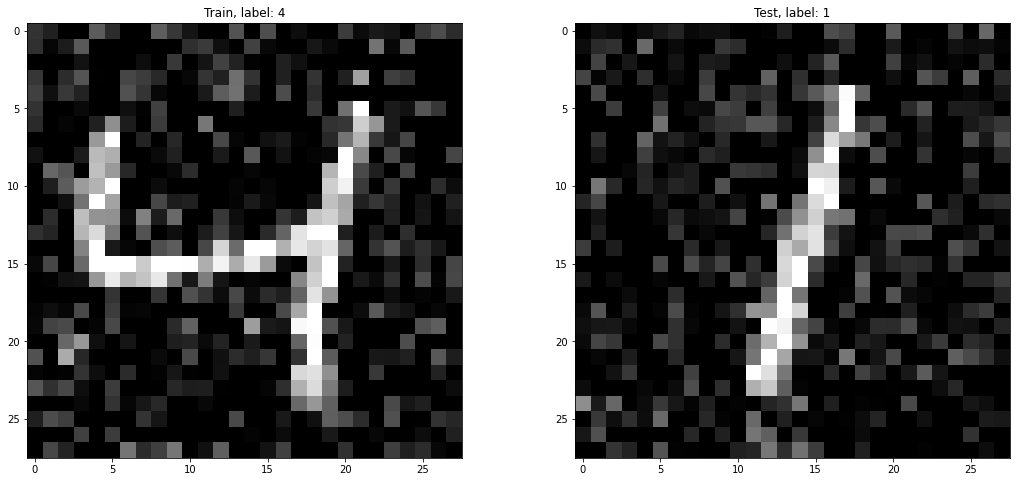

In [9]:
example = 2
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 2, 1)
plt.imshow(X_train_noise[example].reshape(28, 28), "gray")
plt.title("Train, label: " + str(y_train[example]))

plt.subplot(1, 2, 2)
plt.imshow(X_test_noise[example].reshape(28, 28), "gray")
plt.title("Test, label: " + str(y_test[example]))

plt.show()

## Autoencoder
### Architecture

In [10]:
def build_autoencoder(input_shape, hidden, code):
    X_in = keras.Input(input_shape)

    X = layers.Dense(hidden, activation="relu")(X_in)

    X = layers.Dense(code, activation="relu")(X)

    X = layers.Dense(hidden, activation="relu")(X)

    X = layers.Dense(input_shape, activation="sigmoid")(X)
    
    return keras.Model(inputs=X_in, outputs=X)

In [11]:
autoencoder = build_autoencoder(784, 128, 32)
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 784)               101136    
                                                                 
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy()
)

### Train

In [13]:
autoencoder_history = autoencoder.fit(X_train_noise, X_train, batch_size=32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 11s 4ms/step - loss: 0.2360
Epoch 2/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1549
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1366
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1270
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1206


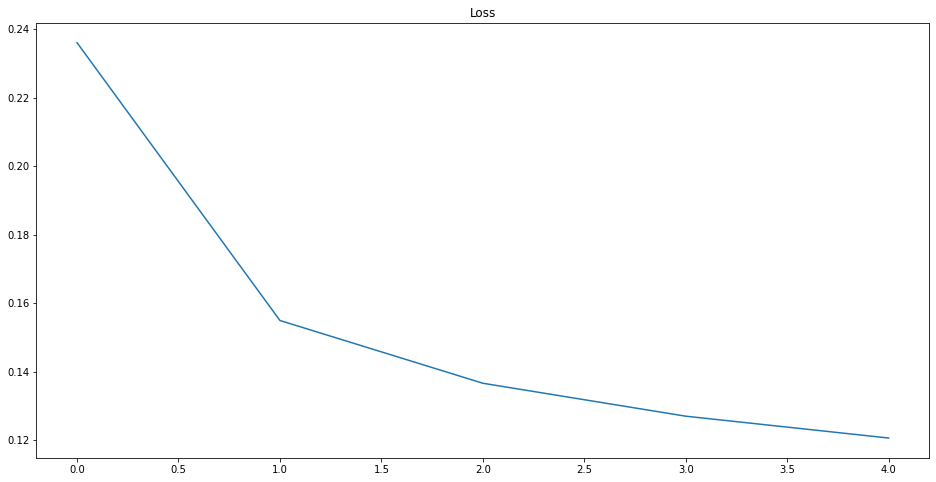

In [14]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.plot(autoencoder_history.history["loss"])
plt.title("Loss")

plt.show()

### Denoised data

In [15]:
X_test_denoised = autoencoder.predict(X_test_noise)

### Preview

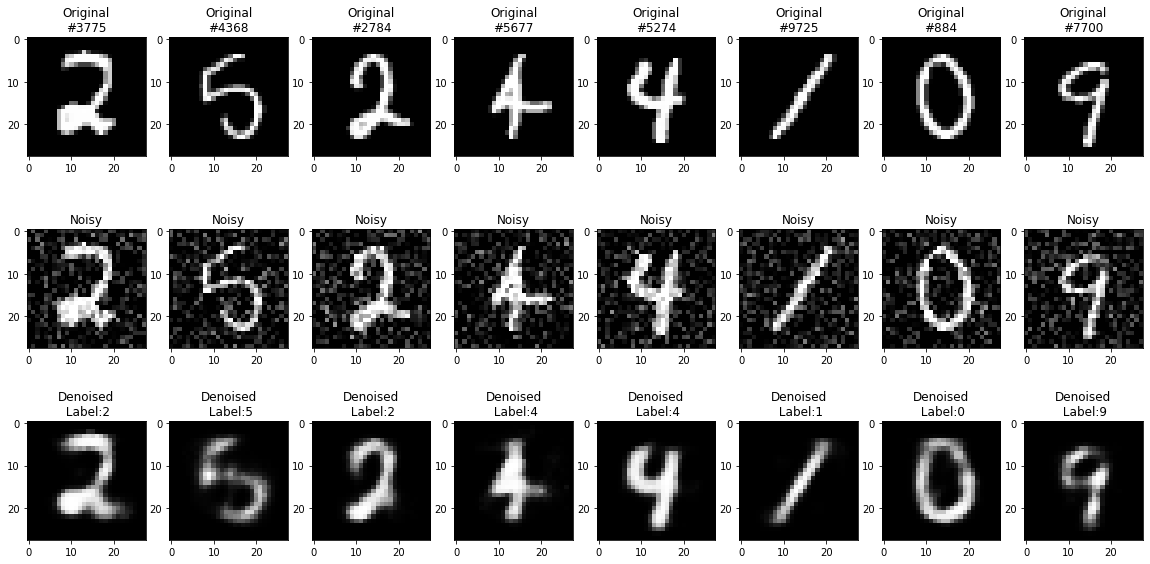

In [37]:
plt.rcParams["figure.figsize"] = (20, 10)
for i in range(8):
    random_example = np.random.randint(0, X_test_noise.shape[0])
    
    plt.subplot(3, 8, i + 1)
    plt.imshow(X_test[random_example].reshape(28, 28), "gray")
    plt.title("Original\n#" + str(random_example))

    plt.subplot(3, 8, i + 9)
    plt.imshow(X_test_noise[random_example].reshape(28, 28), "gray")
    plt.title("Noisy")

    plt.subplot(3, 8, i + 17)
    plt.imshow(X_test_denoised[random_example].reshape(1, 784).reshape(28, 28), "gray")
    plt.title("Denoised\n Label:" + str(y_test[random_example]))

### Save

In [17]:
autoencoder.save("models/autoencoder")

INFO:tensorflow:Assets written to: models/autoencoder\assets


## Model

### Architecture

In [18]:
def build_model(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Dense(256, activation="relu")(X_in)

    X = layers.Dense(128, activation="relu")(X)

    X = layers.Dense(64, activation="relu")(X)

    X = layers.Dense(n_classes, activation="softmax")(X)
    
    return keras.Model(inputs=X_in, outputs=X)

In [19]:
model = build_model(784, 10)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

### Train

In [21]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.05, validation_batch_size=32)

Epoch 1/10
1782/1782 [==============================] - 8s 4ms/step - loss: 0.4702 - sparse_categorical_accuracy: 0.8731 - val_loss: 0.1742 - val_sparse_categorical_accuracy: 0.9510
Epoch 2/10
1782/1782 [==============================] - 6s 3ms/step - loss: 0.1934 - sparse_categorical_accuracy: 0.9449 - val_loss: 0.1202 - val_sparse_categorical_accuracy: 0.9693
Epoch 3/10
1782/1782 [==============================] - 6s 4ms/step - loss: 0.1435 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.1039 - val_sparse_categorical_accuracy: 0.9717
Epoch 4/10
1782/1782 [==============================] - 6s 4ms/step - loss: 0.1135 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.0886 - val_sparse_categorical_accuracy: 0.9757
Epoch 5/10
1782/1782 [==============================] - 6s 3ms/step - loss: 0.0933 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.0808 - val_sparse_categorical_accuracy: 0.9780
Epoch 6/10
1782/1782 [==============================] - 5s 3ms/step - loss: 0.0781 - spars

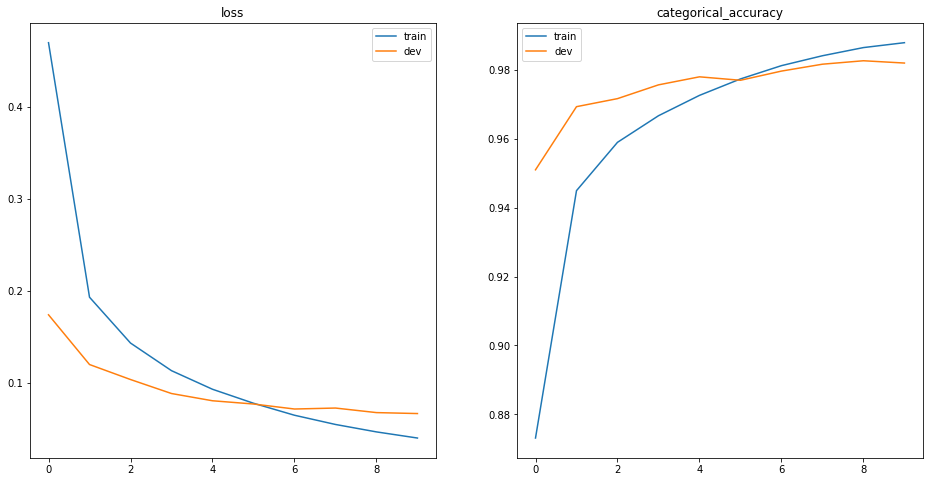

In [22]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["sparse_categorical_accuracy"], label="train")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

### Save

In [23]:
model.save("models/nn")

INFO:tensorflow:Assets written to: models/nn\assets


## Comparing
### Evaluate

In [24]:
print("Standart:", model.evaluate(X_test, y_test, verbose=0))
print("Noisy:", model.evaluate(X_test_noise, y_test, verbose=0))
print("Denoised:", model.evaluate(X_test_denoised, y_test, verbose=0))

Standart: [0.0792744904756546, 0.9750000238418579]
Noisy: [0.49958744645118713, 0.8521999716758728]
Denoised: [0.18595187366008759, 0.9430999755859375]


### Classification Report

In [25]:
y_hat = np.argmax(model.predict(X_test), axis=-1)
y_hat_noise = np.argmax(model.predict(X_test_noise), axis=-1)
y_hat_denoised = np.argmax(model.predict(X_test_denoised), axis=-1)

In [33]:
print("Standart:")
print(metrics.classification_report(y_test, y_hat, target_names=[str(x) for x in range(0, 10)]))

Standart:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.95      0.99      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.96      0.96       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.97      0.97     10000



In [34]:
print("Noise:")
print(metrics.classification_report(y_test, y_hat_noise, target_names=[str(x) for x in range(0, 10)]))

Noise:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.93      0.94      1135
           2       0.90      0.93      0.91      1032
           3       0.62      0.99      0.76      1010
           4       1.00      0.57      0.72       982
           5       0.95      0.87      0.91       892
           6       0.94      0.91      0.93       958
           7       0.97      0.81      0.88      1028
           8       0.63      0.90      0.74       974
           9       0.93      0.63      0.75      1009

    accuracy                           0.85     10000
   macro avg       0.89      0.85      0.85     10000
weighted avg       0.89      0.85      0.85     10000



In [35]:
print("Denoised:")
print(metrics.classification_report(y_test, y_hat_denoised, target_names=[str(x) for x in range(0, 10)]))

Denoised:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.96      0.99      0.97      1135
           2       0.97      0.94      0.95      1032
           3       0.88      0.98      0.92      1010
           4       0.94      0.94      0.94       982
           5       0.94      0.92      0.93       892
           6       0.96      0.96      0.96       958
           7       0.94      0.95      0.94      1028
           8       0.94      0.88      0.91       974
           9       0.95      0.89      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



As we can see, the model's performance dropped from 0.975 to 0.852 with introduction of noise.
Espessially it started struggling with 3, 4, 7, 8, 9. It is obvious how noise can make it difficult to differ between 3, 8, 9.
But after performing denoising with our trained autoencoder we get a substantially better result - 0.943.

## Inference Example
### Load the autoencoder

In [27]:
loaded_autoencoder = tf.keras.models.load_model("models/autoencoder")

### Load the example

In [28]:
example = 5

In [29]:
(_, _), (infer_x, infer_y) = keras.datasets.mnist.load_data()

infer_x = (infer_x[example].reshape(1, -1) / 255).astype(np.float32)
infer_y = infer_y[example]

In [30]:
infer_x_noise = add_noise(infer_x, mean=0, std=0.2, min_clip=0, max_clip=1)

### Infer

In [31]:
infer_x_denoised = loaded_autoencoder.predict(infer_x)

### Preview

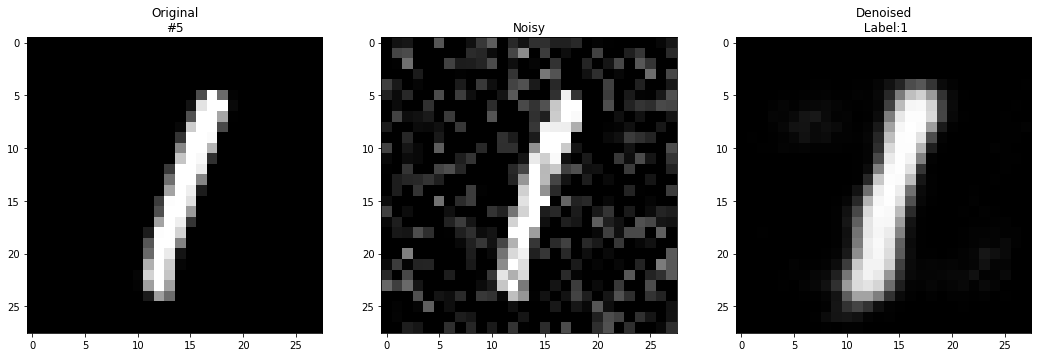

In [36]:
plt.rcParams["figure.figsize"] = (18, 6)

plt.subplot(1, 3, 1)
plt.imshow(infer_x.reshape(28, 28), "gray")
plt.title("Original\n#" + str(example))
plt.subplot(1, 3, 2)
plt.imshow(infer_x_noise.reshape(28, 28), "gray")
plt.title("Noisy")
plt.subplot(1, 3, 3)
plt.imshow(infer_x_denoised.reshape(1, 784).reshape(28, 28), "gray")
plt.title("Denoised\n Label:" + str(infer_y))
plt.show()